In [1]:
import base64
import requests
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image, ImageDraw
from io import BytesIO

In [2]:
class ModelServices():
    def __init__(self, iServers_config = None):
        self.servers_config = iServers_config if iServers_config else {}
    
    def set_detect_objects_server(self, iModel_url):
        self.servers_config["detect_objects"] = iModel_url

    def set_sam_server(self, iModel_url):
        self.servers_config["sam"] = iModel_url

    def detect_objects(self, iImage : Image, iSearched_label = list(), iRoundBoxes = True):
        vBuffer = BytesIO()
        iImage.save(vBuffer, format="JPEG")
        vImageBase64 = base64.b64encode(vBuffer.getvalue()).decode('utf-8')
        
        vJsonRequest = {
            "image": vImageBase64
        }
        vResponse = requests.post(
            self.servers_config["detect_objects"] + "/genera/object_detection",
            json = vJsonRequest
        )

        vResponse = vResponse.json()["data"]
        vFilteredResult = [x for x in vResponse if x["label_name"] in iSearched_label or iSearched_label is None or len(iSearched_label) == 0]
        for tResult in vFilteredResult:
            tResult["box"] = [(round(x) if iRoundBoxes else x) for x in tResult["box"]]
            
            vWidth = tResult["box"][2] - tResult["box"][0]
            vHeigth = tResult["box"][3] - tResult["box"][1]
            tResult["width"] = vWidth
            tResult["heith"] = vHeigth
            tResult["area"] = vWidth * vHeigth
            tResult["relative_area"] = (vWidth * vHeigth) / (iImage.size[0] * iImage.size[1])
        return vFilteredResult

    def generate_masks(self, iImage, iBoxes):
        vBuffer = BytesIO()
        iImage.save(vBuffer, format="JPEG")
        vImageBase64 = base64.b64encode(vBuffer.getvalue())
        vImageBase64 = vImageBase64.decode('utf-8')
        vJsonRequest = {
            "image": vImageBase64,
            "boxes": iBoxes,
            "shape": iImage.size
        }

        vResponse = requests.post(
            self.servers_config["sam"] + "/genera/segments/box",
            json = vJsonRequest
        )
        vMasks = list()
        for tMask in vResponse.json()["masks"]:
            tMask = base64.b64decode(tMask)
            tMask = Image.open(BytesIO(tMask))
            vMasks.append(tMask)
        return vMasks

gAIServer = ModelServices()
gAIServer.set_detect_objects_server("http://localhost:88")
gAIServer.set_sam_server("http://localhost:80")

In [3]:
def plot_images(iImages, iFigSize = (5, 5)):
    if isinstance(iFigSize, int):
        iFigSize = (iFigSize, iFigSize)
    if isinstance(iImages, list) and len(iImages) > 1:
        plt.figure(figsize = iFigSize)
        _, vAxisArray = plt.subplots(1, len(iImages), figsize = iFigSize)
        for i, tImage in enumerate(iImages):
            vAxisArray[i].imshow(tImage)
            vAxisArray[i].axis('off')
        plt.show()
    else:
        vImage = iImages[0] if isinstance(iImages, list) and len(iImages) == 1 else iImages
        plt.figure(figsize = iFigSize)
        plt.imshow(vImage)
        plt.axis('off')
        plt.show()

<Figure size 1500x1500 with 0 Axes>

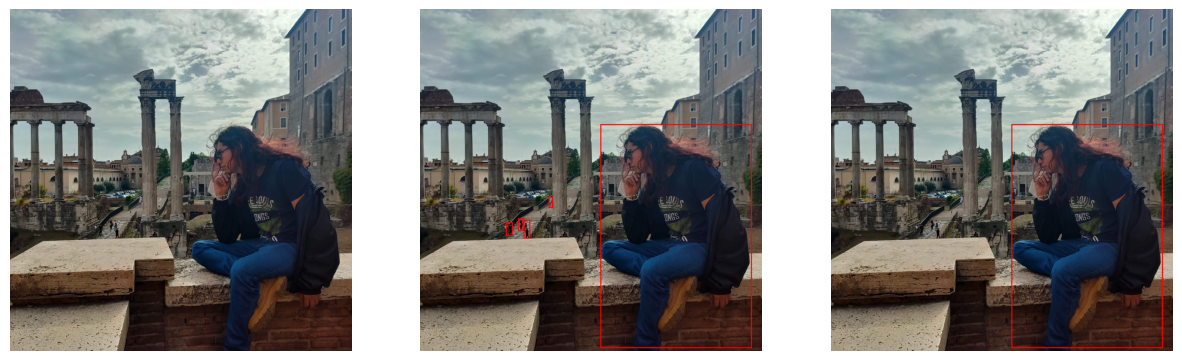

In [4]:
def numpy2pillow(iNumpyArray : np.ndarray) -> Image:
    return Image.fromarray(iNumpyArray)

def pillow2numpy(iImage : Image) -> np.ndarray:
    return np.array(iImage)

def draw_boxes(iImage, iBoxes, iColor, iWidth):
    vImage = iImage.copy()
    vDraw = ImageDraw.Draw(vImage)
    for tBox in [x for x in iBoxes]:
        vDraw.rectangle(tBox["box"], outline = iColor, width = iWidth)
    return vImage

gImage = Image.open("../resources/images/user-model.jpg")
gObjectsDetecteds = gAIServer.detect_objects(gImage, "person")

gObjectsFiltered = [x for x in gObjectsDetecteds if x["relative_area"] > 0.2]

gImageWithBoxes = draw_boxes(gImage, gObjectsDetecteds, "red", 5)
gImageWithBoxesWithFilter = draw_boxes(gImage, gObjectsFiltered, "red", 5)

plot_images([gImage, gImageWithBoxes, gImageWithBoxesWithFilter], 15)

<Figure size 1200x1200 with 0 Axes>

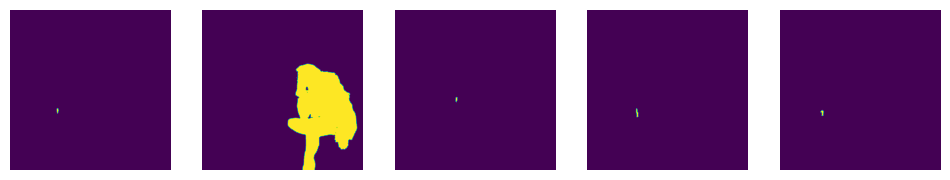

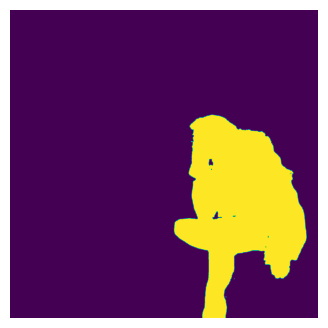

In [5]:
gBoxes = [x["box"] for x in gObjectsDetecteds]
gMasks = gAIServer.generate_masks(gImage, gBoxes)

gBoxesFiltered = [x["box"] for x in gObjectsDetecteds if x["relative_area"] > 0.2]
gMasksFiltered = gAIServer.generate_masks(gImage, gBoxesFiltered)

plot_images(gMasks, 12)
plot_images(gMasksFiltered, 4)

In [6]:
def crop_image(iImage, iBox):
    vImgArray = np.array(iImage)
    vImage = vImgArray[ iBox[1] : iBox[3] , iBox[0] : iBox[2]]
    vImage = Image.fromarray(vImage)
    return vImage

def remove_mask(iImage, iMask, iInverseRemove : bool = False):
    vImage = np.array(iImage)
    vMask  = np.array(iMask)
    
    vAlphaChannel = vMask * np.ones(vImage.shape[:2], dtype = np.uint8)
    if iInverseRemove:
        vAlphaChannel = 255 - vAlphaChannel

    return np.dstack((vImage, vAlphaChannel))

def combine_masks(iMaskList):
    vMaskResult = iMaskList[0]
    for iMask in iMaskList:
        vMaskResult = np.maximum(vMaskResult, iMask)
    return vMaskResult

<Figure size 1000x1000 with 0 Axes>

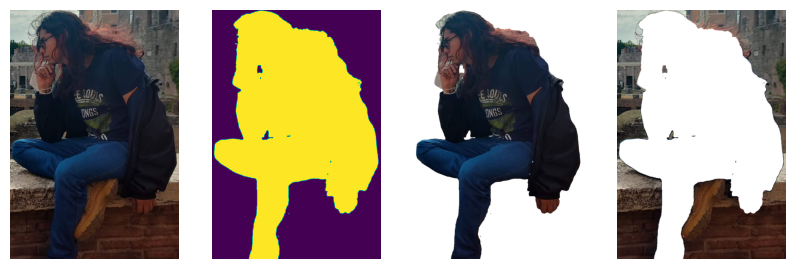

<Figure size 1500x1500 with 0 Axes>

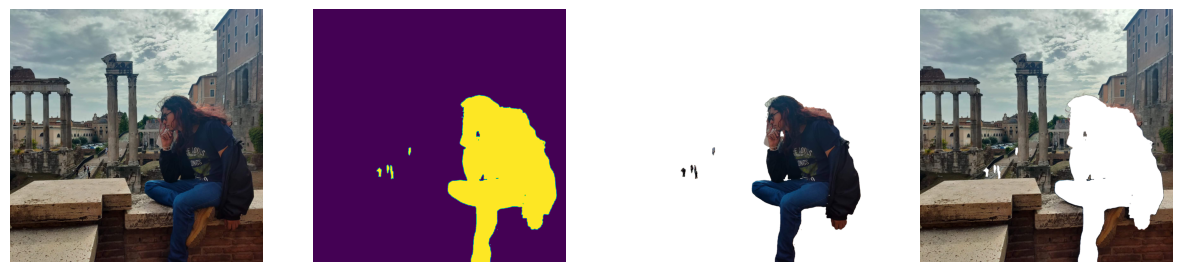

In [7]:
gWholeMask = combine_masks(gMasks)
gWholeCrop = remove_mask(gImage, gWholeMask)
gWholeCropInv = remove_mask(gImage, gWholeMask, True)

gImageCropped = crop_image(gImage, gBoxesFiltered[0])
gMaskCropped = crop_image(gMasksFiltered[0], gBoxesFiltered[0])
gImageMasked = remove_mask(gImageCropped, gMaskCropped, False)
gBackgMasked = remove_mask(gImageCropped, gMaskCropped, True)

plot_images([gImageCropped, gMaskCropped, gImageMasked, gBackgMasked], 10)
plot_images([gImage, gWholeMask, gWholeCrop, gWholeCropInv], 15)